In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Required Library
!pip install seqeval==0.0.12

  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7423 sha256=713e987387b00afe6189385a02d63e085f5897410e813524adcba85a032e863c
  Stored in directory: /root/.cache/pip/wheels/1f/1b/a6/a808a7e4d1f7584e42f5e279664cd48bf24ed8392218ce6be4
Successfully built seqeval


In [3]:
# Importing required Libraries
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm,trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import json
import random
import logging
import re
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Using TensorFlow backend.


In [4]:
data_file_address = "../input/resume-entities-for-ner//Entity Recognition in Resumes.json"

In [5]:
# Reading data
df_data = pd.read_json(data_file_address, lines=True)
df_data.head(10)

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN
5,Anvitha Rao\nAutomation developer\n\n- Email m...,"[{'label': ['Skills'], 'points': [{'start': 28...",NaN
6,arjun ks\nSenior Program coordinator - oracle ...,"[{'label': ['Skills'], 'points': [{'start': 34...",NaN
7,"Arun Elumalai\nQA Tester\n\nChennai, Tamil Nad...","[{'label': ['Skills'], 'points': [{'start': 19...",NaN
8,Ashalata Bisoyi\nTransaction Processor - Oracl...,"[{'label': ['Skills'], 'points': [{'start': 17...",NaN
9,Ashok Kunam\nTeam Lead - Microsoft\n\n- Email ...,"[{'label': ['Skills'], 'points': [{'start': 41...",NaN


In [6]:
# Removing New Line characters
for i in range(len(df_data)):
    df_data["content"][i] = df_data["content"][i].replace("\n", " ")
df_data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,content,annotation,extras
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [7]:
# JSON formatting functions
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data        

In [8]:
data = trim_entity_spans(convert_dataturks_to_spacy(data_file_address))
data[0]

["Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Le

In [9]:
# Changing data to appropriate format so as to feed it to the model
from tqdm import tqdm_notebook as tqdm
cleanedDF = pd.DataFrame(columns=["setences_cleaned"])
sum1 = 0
for i in tqdm(range(len(data))):
    start = 0
    emptyList = ["Empty"] * len(data[i][0].split())
    numberOfWords = 0
    lenOfString = len(data[i][0])
    strData = data[i][0]
    strDictData = data[i][1]
    lastIndexOfSpace = strData.rfind(' ')
    for i in range(lenOfString):
        if (strData[i]==" " and strData[i+1]!=" "):
            for k,v in strDictData.items():
                for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (start>=int(entList[0]) and i<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        break
                    else:
                        continue
            start = i + 1  
            numberOfWords += 1
        if (i == lastIndexOfSpace):
            for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (lastIndexOfSpace>=int(entList[0]) and lenOfString<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        numberOfWords += 1
    cleanedDF = cleanedDF.append(pd.Series([emptyList],  index=cleanedDF.columns ), ignore_index=True )
    sum1 = sum1 + numberOfWords

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [10]:
cleanedDF.head()

,setences_cleaned
0,"[Name, Name, Designation, Designation, Designa..."
1,"[Name, Name, Empty, Empty, Empty, Empty, Empty..."
2,"[Name, Name, Name, Empty, Empty, Empty, Empty,..."
3,"[Name, Name, Designation, Designation, Designa..."
4,"[Name, Name, Designation, Empty, Companies wor..."


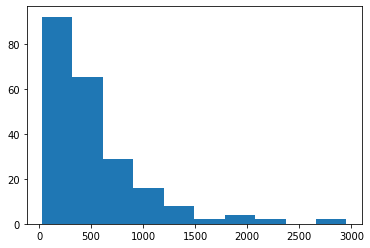

In [11]:
import matplotlib.pyplot as plt
totalNumWords = [len(one_comment.split()) for one_comment in df_data["content"]]
plt.hist(totalNumWords)
plt.show()

In [12]:
MAX_LEN = 300
bs = 16

In [14]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
from keras.preprocessing.text import Tokenizer 
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_data["content"])

In [15]:
tokenized_texts = tokenizer.texts_to_sequences(df_data["content"])
# tokenized_texts = [tokenizer.tokenize(sent) for sent in df_data["content"]]
print(tokenized_texts[0])

[3331, 3332, 37, 52, 302, 517, 150, 72, 62, 59, 8, 11, 11, 13, 17, 3331, 3332, 4387, 2, 4, 23, 7, 88, 193, 105, 603, 59, 3, 890, 4, 814, 120, 20, 1, 58, 7, 120, 843, 1, 2736, 448, 5, 341, 1354, 2079, 190, 4, 198, 4, 154, 72, 23, 16, 37, 52, 302, 517, 320, 111, 4, 91, 163, 534, 76, 8, 1733, 2737, 289, 1891, 39, 1734, 449, 7, 3, 2737, 105, 244, 139, 3333, 97, 8, 481, 1355, 221, 130, 3, 2737, 7, 172, 1354, 6000, 408, 786, 1, 3334, 105, 244, 139, 481, 15, 1355, 41, 3, 128, 63, 143, 234, 5, 54, 241, 1, 145, 143, 535, 143, 159, 6, 145, 1, 78, 3335, 72, 257, 110, 4, 131, 111, 2738, 5, 2739, 6001, 3336, 202, 283, 175, 4, 290, 110, 2381, 6002, 6003, 283, 1263, 4, 290, 175, 20, 73, 67, 56, 24, 33, 83, 67, 56, 24, 33, 83, 12, 67, 56, 24, 33, 83, 12, 44, 67, 56, 24, 33, 81, 67, 56, 24, 33, 100, 54, 45, 20, 32, 34, 11, 13, 17, 3331, 3332, 4387, 47, 48, 14, 49, 14, 43, 35, 5, 2, 267, 329, 73, 73, 81, 2, 39, 1734, 2, 815, 6, 2382, 2, 891, 426, 2, 83, 12, 44, 2, 170, 1086, 2, 192, 44, 66, 8, 188, 71, 

In [16]:
input_ids = pad_sequences(tokenized_texts,
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [17]:
tags_vals = ["UNKNOWN", "Name", "Degree","Skills","College Name","Email Address","Designation","Companies worked at","Empty","Graduation Year","Years of Experience","Location"]
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [18]:
labels = cleanedDF["setences_cleaned"].tolist()

In [19]:
print(set(labels[61]))

{'Degree', 'College Name', 'Companies worked at', 'Name', 'Empty', 'Years of Experience', 'UNKNOWN', 'Skills', 'Designation'}


In [20]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["Empty"], padding="post",
                     dtype="long", truncating="post")

In [21]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [22]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [23]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [24]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [25]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

100%|██████████| 407873900/407873900 [00:12<00:00, 33102856.13B/s]


In [26]:
model.cuda();

In [27]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [28]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
epochs = 5
max_grad_norm = 1.0

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.8511637701438024


Epoch:  20%|██        | 1/5 [00:08<00:34,  8.66s/it]

Validation loss: 0.5098541527986526
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
Train loss: 0.5241081989728488


Epoch:  40%|████      | 2/5 [00:16<00:25,  8.43s/it]

Validation loss: 0.4943576753139496
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
Train loss: 0.5169478012965276


Epoch:  60%|██████    | 3/5 [00:24<00:16,  8.26s/it]

Validation loss: 0.515742152929306
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
Train loss: 0.5097572069901687


Epoch:  80%|████████  | 4/5 [00:32<00:08,  8.15s/it]

Validation loss: 0.48067526519298553
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
Train loss: 0.484199753174415


Epoch: 100%|██████████| 5/5 [00:40<00:00,  8.06s/it]

Validation loss: 0.5480965077877045
Validation Accuracy: 0.9231944444444444
F1-Score: 0.9242331288343558
